<a href="https://colab.research.google.com/github/Maryam9292/Data-Analytics-and-Data-Science/blob/main/Claims_Cost_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Load data
df = pd.read_csv("insurance.csv")

# Check for missing values
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [ ]:
# Generate synthetic pre-existing conditions based on age, BMI, and smoking status
np.random.seed(42)
def assign_condition(row):
    prob = 0.0
    if row['age'] >= 50: prob += 0.6
    if row['bmi'] >= 30: prob += 0.5
    if row['smoker'] == 'yes': prob += 0.4
    prob = min(prob, 0.85)  # Cap probability at 85%
    return np.random.binomial(1, prob)

df['pre_existing_condition'] = df.apply(assign_condition, axis=1)

In [ ]:
# Age groups
df['age_group'] = pd.cut(df['age'], bins=[17, 30, 45, 60, 100], labels=['18-30', '31-45', '46-60', '60+'])

# BMI categories
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['Underweight', 'Healthy', 'Overweight', 'Obese'])

import numpy as np

df['smoker_encoded'] = np.where(df['smoker'] == 'yes', 1, 0)

In [ ]:
df

,age,sex,bmi,children,smoker,region,charges,pre_existing_condition,age_group,bmi_category,smoker_encoded
0,19,female,27.900,0,yes,southwest,16884.92400,0,18-30,Overweight,1
1,18,male,33.770,1,no,southeast,1725.55230,1,18-30,Obese,0
2,28,male,33.000,3,no,southeast,4449.46200,1,18-30,Obese,0
3,33,male,22.705,0,no,northwest,21984.47061,0,31-45,Healthy,0
4,32,male,28.880,0,no,northwest,3866.85520,0,31-45,Overweight,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,46-60,Obese,0
1334,18,female,31.920,0,no,northeast,2205.98080,1,18-30,Obese,0
1335,18,female,36.850,0,no,southeast,1629.83350,1,18-30,Obese,0
1336,21,female,25.800,0,no,southwest,2007.94500,0,18-30,Overweight,0


Skewness: 1.52


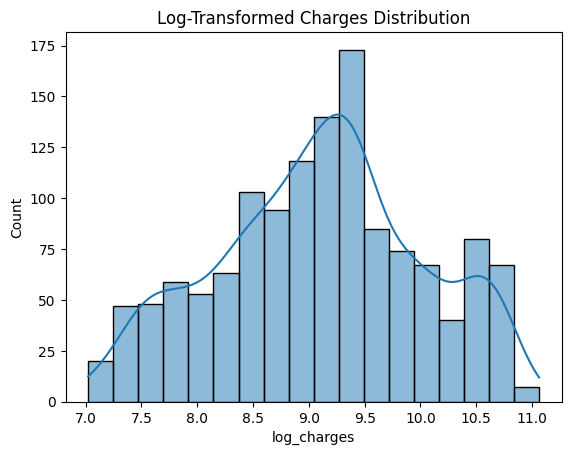

In [ ]:
# Check skewness
print(f"Skewness: {df['charges'].skew():.2f}")  # Likely highly skewed (original dataset skewness: 1.51)

# Log transformation to reduce skewness
df['log_charges'] = np.log1p(df['charges'])
sns.histplot(df['log_charges'], kde=True)
plt.title('Log-Transformed Charges Distribution')
plt.show()

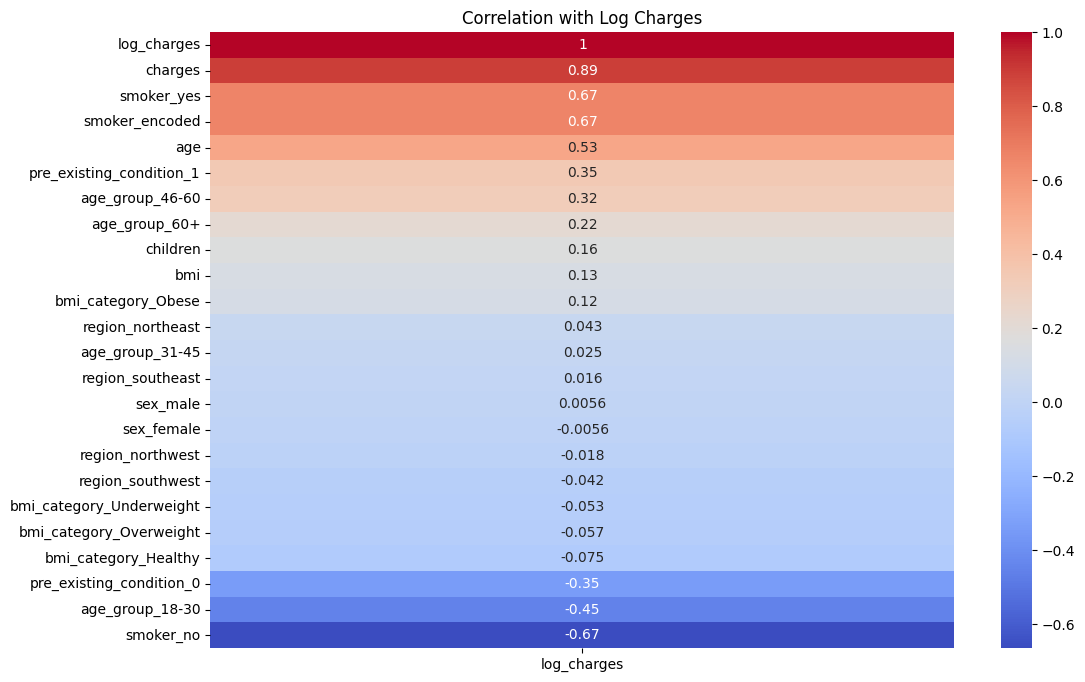

In [ ]:
# Encode categorical variables for correlation
df_encoded = pd.get_dummies(df, columns=['smoker', 'sex', 'region', 'age_group', 'bmi_category', 'pre_existing_condition'])

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr()[['log_charges']].sort_values('log_charges', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with Log Charges')
plt.show()

In [ ]:
# Identify top 20% high-cost claimants
high_cost_threshold = df['charges'].quantile(0.8)
high_cost = df[df['charges'] > high_cost_threshold]

# Profile high-cost claimants
print(high_cost[['smoker', 'pre_existing_condition', 'bmi_category']].value_counts(normalize=True))

smoker  pre_existing_condition  bmi_category
yes     1                       Obese           0.455224
                                Overweight      0.085821
no      1                       Obese           0.082090
yes     0                       Obese           0.082090
                                Overweight      0.074627
        1                       Healthy         0.063433
no      0                       Overweight      0.048507
                                Healthy         0.041045
                                Obese           0.037313
        1                       Overweight      0.014925
yes     0                       Healthy         0.011194
                                Underweight     0.003731
Name: proportion, dtype: float64


In [ ]:
# Create 'high_risk' column
df['high_risk'] = df.apply(
    lambda x: 1 if (x['smoker'] == 'yes' and x['bmi'] >= 30 and x['pre_existing_condition'] == 1) else 0,
    axis=1
)

In [ ]:
# Define features and target
X = df.drop(['charges', 'log_charges'], axis=1)
y = df['log_charges']  # Use log-transformed target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Categorical and numerical features
cat_features = ['sex', 'smoker', 'region', 'age_group', 'bmi_category']
num_features = ['age', 'bmi', 'children', 'pre_existing_condition']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

In [ ]:
# Define pipeline
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# No hyperparameters to tune for Linear Regression
# Fit and evaluate
scores_lr = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='r2')
print(f"Linear Regression R2: {np.mean(scores_lr):.2f}")

Linear Regression R2: 0.75


In [ ]:
# Define pipeline
pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Hyperparameter grid
param_grid_ridge = {
    'regressor__alpha': [0.01, 0.1, 1, 10]  # Regularization strength
}

# Grid search
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='r2', verbose=1)
grid_ridge.fit(X_train, y_train)

# Best model
best_ridge = grid_ridge.best_estimator_
print(f"Best Ridge R2: {grid_ridge.best_score_:.2f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Ridge R2: 0.75


In [ ]:
# Define pipeline
pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Hyperparameter grid
param_grid_lasso = {
    'regressor__alpha': [0.01, 0.1, 1, 10]  # Regularization strength
}

# Grid search
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='r2', verbose=1)
grid_lasso.fit(X_train, y_train)

# Best model
best_lasso = grid_lasso.best_estimator_
print(f"Best Lasso R2: {grid_lasso.best_score_:.2f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Lasso R2: 0.75


In [ ]:
# Define pipeline
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid
param_grid_rf = {
    'regressor__n_estimators': [100, 200],  # Number of trees
    'regressor__max_depth': [None, 10, 20],  # Maximum depth of trees
    'regressor__min_samples_split': [2, 5]  # Minimum samples to split a node
}

# Grid search
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='r2', verbose=1)
grid_rf.fit(X_train, y_train)

# Best model
best_rf = grid_rf.best_estimator_
print(f"Best Random Forest R2: {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Random Forest R2: 0.81


In [ ]:
# Define pipeline
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Hyperparameter grid
param_grid_gb = {
    'regressor__n_estimators': [100, 200],  # Number of boosting stages
    'regressor__learning_rate': [0.05, 0.1],  # Shrinkage factor
    'regressor__max_depth': [3, 5]  # Maximum depth of trees
}

# Grid search
grid_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='r2', verbose=1)
grid_gb.fit(X_train, y_train)

# Best model
best_gb = grid_gb.best_estimator_
print(f"Best Gradient Boosting R2: {grid_gb.best_score_:.2f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Gradient Boosting R2: 0.82


In [ ]:
results = {
    'Linear Regression': np.mean(scores_lr),
    'Ridge Regression': grid_ridge.best_score_,
    'Lasso Regression': grid_lasso.best_score_,
    'Random Forest': grid_rf.best_score_,
    'Gradient Boosting': grid_gb.best_score_
}

# Display results
results_df = pd.DataFrame(results.items(), columns=['Model', 'R2 Score'])
results_df = results_df.sort_values('R2 Score', ascending=False)
print(results_df)

               Model  R2 Score
4  Gradient Boosting  0.821737
3      Random Forest  0.812137
1   Ridge Regression  0.751129
0  Linear Regression  0.751057
2   Lasso Regression  0.748561


In [ ]:
# Predict on test data
y_pred = best_gb.predict(X_test)

# Inverse log transformation
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Metrics
print(f"R2: {r2_score(y_test_actual, y_pred_actual):.2f}")
print(f"MAE: ${mean_absolute_error(y_test_actual, y_pred_actual):.2f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)):.2f}")

R2: 0.88
MAE: $1981.89
RMSE: $4397.75


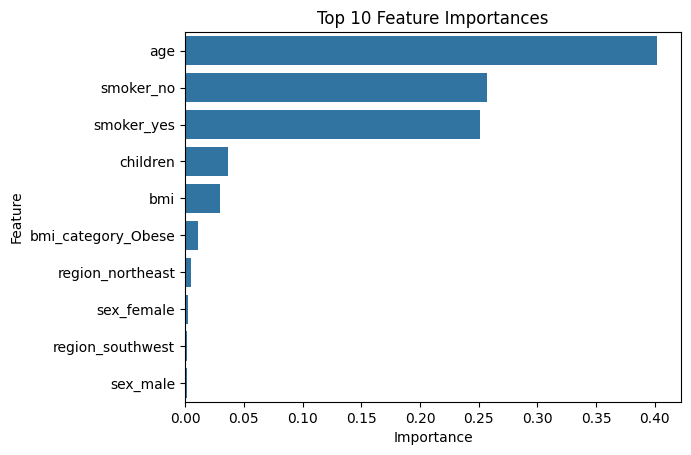

In [ ]:
# Extract feature names from OneHotEncoder
cat_encoder = best_gb.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(cat_features)
all_features = num_features + list(cat_feature_names)

# Get feature importances
importances = best_gb.named_steps['regressor'].feature_importances_

# Plot top 10 features
feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(10)

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 10 Feature Importances')
plt.show()

In [ ]:
df

,age,sex,bmi,children,smoker,region,charges,pre_existing_condition,age_group,bmi_category,smoker_encoded,log_charges,high_risk
0,19,female,27.900,0,yes,southwest,16884.92400,0,18-30,Overweight,1,9.734236,0
1,18,male,33.770,1,no,southeast,1725.55230,1,18-30,Obese,0,7.453882,0
2,28,male,33.000,3,no,southeast,4449.46200,1,18-30,Obese,0,8.400763,0
3,33,male,22.705,0,no,northwest,21984.47061,0,31-45,Healthy,0,9.998137,0
4,32,male,28.880,0,no,northwest,3866.85520,0,31-45,Overweight,0,8.260455,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,46-60,Obese,0,9.268755,0
1334,18,female,31.920,0,no,northeast,2205.98080,1,18-30,Obese,0,7.699381,0
1335,18,female,36.850,0,no,southeast,1629.83350,1,18-30,Obese,0,7.396847,0
1336,21,female,25.800,0,no,southwest,2007.94500,0,18-30,Overweight,0,7.605365,0


In [ ]:
df.to_csv("final_insurance_dataset.csv", index=False)